In [53]:
#imports
import numpy as np
import scipy.stats as stats
import os
import matplotlib.pyplot as plt

### Feature extraction
train will have the training samples and test will have the test samples

In [2]:
#speaker dependent partitions
#sdeptrain dimensions sdeptrain[speaker][word][utterance idx] with idxs given alphabetically
sdeptrain = [[[[] for i in range(4)] for j in range(5)] for k in range(4)]
#sdeptest dimensions sdeptrain[speaker][word] with idxs given alphabetically
sdeptest = [[[] for i in range(5)] for j in range(4)]
p = './feature'
speakerList = ['dg', 'ls', 'mh', 'yx']
wordList = ['asr','cnn','dnn','hmm','tts']
snum = 0
for s in speakerList:
    speakerpath = p+'/'+s
    wnum = 0
    for w in wordList:
        wordpath = speakerpath +'/'+s+'_'+w
        #set up train
        for utt in range(1,5):
            fpath = wordpath + str(utt)+'.fea'
            f = open(fpath,'r')
            data = f.readlines()
            data = [i.split(',') for i in data]
            for sample in range(len(data)):
                data[sample] = [float(i) for i in data[sample]]
            for d in data:
                sdeptrain[snum][wnum][utt-1].append(d)
        #set up test
        fpath2 = wordpath + str(5)+'.fea'
        f2 = open(fpath2,'r')
        data = f2.readlines()
        data = [i.split(',') for i in data]
        for d in data:
            sdeptest[snum][wnum].append(d)
        wnum += 1
    snum += 1
sdeptrain = np.array(sdeptrain)


bigasr = []
bigcnn = []
bigdnn = []
bighmm = []
bigtts = []
for i in range(4):
    for j in range(4):
        bigasr.extend(sdeptrain[i][0][j])
        bigcnn.extend(sdeptrain[i][1][j])
        bigdnn.extend(sdeptrain[i][2][j])
        bighmm.extend(sdeptrain[i][3][j])
        bigtts.extend(sdeptrain[i][4][j])
sdepasr_cov = np.diag(np.diag(np.cov(np.array(bigasr).T)))
sdepcnn_cov = np.diag(np.diag(np.cov(np.array(bigcnn).T)))
sdepdnn_cov = np.diag(np.diag(np.cov(np.array(bigdnn).T)))
sdephmm_cov = np.diag(np.diag(np.cov(np.array(bighmm).T)))
sdeptts_cov = np.diag(np.diag(np.cov(np.array(bigtts).T)))
sdepasr_mn = np.mean(bigasr,axis=0)
sdepcnn_mn = np.mean(bigcnn,axis=0)
sdepdnn_mn = np.mean(bigdnn,axis=0)
sdephmm_mn = np.mean(bighmm,axis=0)
sdeptts_mn = np.mean(bigtts,axis=0)
print(sdepasr_mn)

[-1.41283743e+00 -1.55428945e+01  2.92278843e+00  1.49472286e-01
  6.35381972e-01  2.16369842e-01  1.42493539e-01  5.27392847e-02
  2.55955474e-01  5.94233038e-02  1.82504452e-01  4.46193938e-03
  4.64175756e-02 -1.72107996e-02]


In [3]:
# print(sdeptrain[0][0])

In [4]:
#speaker independent partitions
#Extract feature vectors
p = './feature'
#test separetes each utterance of each word of each speaker
test = []
train = []
#test_big chunks all utterances of each word for each speaker
test_big = []
train_big = []
dirList = ['dg', 'ls', 'mh', 'yx']
for d in os.listdir(p):
    #put mh in the test set
    if d == 'mh':
        dirpath = p + '/' + d
        filelist = os.listdir(dirpath)
        word = [[] for i in range(5)]
        word_big = [[] for i in range(5)]
        for i in range(len(filelist)):
            f = open(dirpath + '/' + filelist[i])
            data_ = f.readlines() 
            data = [i.split(',') for i in data_]
            for sample in range(len(data)):
                data[sample] = [float(s) for s in data[sample] ]
            word[i//5].append(data)
            word_big[i//5].extend(data)
        test.append(word)
        test_big.append(word_big)
    else:
        if d in dirList:
            #put all others in train
            dirpath = p + '/' + d
            filelist = os.listdir(dirpath)
            word = [[] for i in range(5)]
            word_big = [[] for i in range(5)]
            for i in range(len(filelist)):
                f = open(dirpath + '/' + filelist[i])
                data_ = f.readlines() 
                data = [i.split(',') for i in data_]
                for sample in range(len(data)):
                    data[sample] = [float(s) for s in data[sample] ]
                word[i//5].append(data)
                word_big[i//5].extend(data)
            train.append(word)
            train_big.append(word_big)

In [5]:
print(len(train_big),len(train_big[0]))

3 5


In [6]:
#speaker dependent hmm

print(np.exp(1))

2.718281828459045


In [7]:
a = [[1,1,1],
     [2,2,2],
     [3,3,3]]

a_ = [a[-i] for i in range(1,len(a)+1)]
print(a_)

[[3, 3, 3], [2, 2, 2], [1, 1, 1]]


In [25]:
##### HELPER FUNCTIONSSSSS
#implemented from https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm

#Forward Pass

def calculateBMatrix(X, mu, sigma,N):
    #X is the data in a file
    #mu is the average across all states 
    #sigma is the covariance matrix across all states 
    #N is the number of states
    #BMatrix = [T,N]
    #print(sigma[0])
    T = len(X)
    bMatrix = np.zeros((N,T))
    for frame in range(T):
        temp_frame = []
        for state in range(N):
            bMatrix[state,frame] = stats.multivariate_normal(mean=(mu[state]),cov=sigma[state]).pdf(X[frame])
    return bMatrix

def calculateAlphaMatrix(transMatrix, BMatrix,priors):
    #transMatrix is A 
    #BMatrix is B
    #priors is pi
    #populate our alpha matrix
    T = len(BMatrix[0])
    N = len(BMatrix)
    Amat = np.array(transMatrix)
    alpha = np.zeros((N,T))
    #alphaMatrix = [T,N]
    for i in range(N):
        alpha[i,0]=priors[i]*BMatrix[i,0]
    for t in range(1,T):
        for i in range(0,N):
            alpha[i,t]=BMatrix[i,t]*np.inner(alpha[:,t-1],Amat[:,i])       
    return alpha

def calculateAlphaBetaTildeG(transMatrix,BMatrix,priors):
    T = len(BMatrix[0])
    N = len(BMatrix)
    baralpha = np.zeros((N,T))
    tildealpha = np.zeros((N,T))
    tildebeta = np.zeros((N,T))
    log_g = np.zeros((T))
    for i in range(0,N):
        baralpha[i,0]=priors[i]*BMatrix[i,0]
    log_g[0] = np.log(np.sum(baralpha[:,0]))
    tildealpha[:,0]=baralpha[:,0]/np.exp(log_g[0])

    for t in range(1,T):
        for i in range(0,N):
            baralpha[i,t]=BMatrix[i,t]*np.inner(tildealpha[:,t-1],transMatrix[:,i])
        log_g[t] = np.log(np.sum(baralpha[:,t]))
        tildealpha[:,t]=baralpha[:,t]/np.exp(log_g[t])
    for i in range(0,N):
        tildebeta[i,T-1] = 1/np.exp(log_g[T-1])

    for t in range(T-2,-1,-1):
        for i in range(0,N):
            tildebeta[i,t]=np.inner(transMatrix[i,0:N],tildebeta[:,t+1]*B[:,t+1])/np.exp(log_g[t+1])
    
    return tildealpha,tildebeta,log_g
#Backward Pass
    
def calculateBetaMatrix(transMatrix, bMatrix):
    #populate the Beta matrix
    T = len(bMatrix[0])
    N = len(bMatrix)
    beta = np.zeros((N,T))
    for i in range(N):
        beta[i,T-1]=1
    for t in range(T-2,-1,-1):
        for i in range(0,N):
            beta[i,t]=np.inner(transMatrix[i,0:N],beta[:,t+1]*bMatrix[:,t+1])
    return beta
#Update step helper functions

def calculateGammaMatrix(alphaMatrix, betaMatrix):
    T = len(betaMatrix[0])
    N = len(betaMatrix)
    gamma = np.zeros((N,T))
    for t in range(T):
       # print("ALPHA",alphaMatrix[:,t])
       # print("BETA",betaMatrix[:,t])
        gamma[:,t]=alphaMatrix[:,t]*betaMatrix[:,t]
        gamma[:,t]=gamma[:,t]/np.sum(gamma[:,t])
#     sumList = np.zeros((T))
#     for f in range(T):
#         for n in range(N):
#             sumList[f] += alphaMatrix[f][n]*betaMatrix[f][n]
#     #sumList = [sum([alphaMatrix[f][n] * betaMatrix[f][n] for n in range(N)]) for f in range(T)]
#     gammaMatrix = []
#     for frame in range(T):
#         temp_frame = []
#         for state in range(N):
#             temp_frame.append(alphaMatrix[frame][state] / sumList[frame])
#         gammaMatrix.append(temp_frame)
    return gamma

def calculateXiMatrix( transMatrix, alphaMatrix, betaMatrix, bMatrix):
    #caluculate xi 
    #probability of going from state n to state j at times t and t+1 respectively
    T = len(bMatrix[0])
    N = len(bMatrix)
    xi = np.zeros((2*N,T))
    for t in range(0,T):
        for i in range(0,N):
            for j in range(i,i+2):
                if j>= N:
                    xi[i+j,t] = 0
                else:
                    xi[i+j,t]=alphaMatrix[i,t]*transMatrix[i,j]
                if (t<T-1):
                    if j==N:
                        xi[i+j,t]=0
                    else:
                        xi[i+j,t] = xi[i+j,t]*bMatrix[j,t+1]*betaMatrix[j,t+1]
        xi[:,t]=xi[:,t]/np.sum(xi[:,t])
    
#     for frame in range(T):
#         for state in range(N):
#             for state_ in range(state, state + 2):
#                 xiMatrix[frame, state + state_] = alphaMatrix[frame, state] * transMatrix[state][state_]
#                 if frame < (T-1):
#                     if state_ == N:
#                         xiMatrix[frame, state + state_] = 0
#                     else:
#                         xiMatrix[frame, state + state_] = xiMatrix[frame, state + state_] * bMatrix[frame + 1, state_] * betaMatrix[frame+1, state_]
#         xi[:,t]=xi[:,t]/np.sum(xi[:,t])
#         xiMatrix[frame,:] = xiMatrix[frame,:]/np.sum(xiMatrix[frame, :]) 
    
    return xi 



In [26]:
#speaker independent hmm
initialProbabilities = [0.2, 0.2, 0.2, 0.2, 0.2]

initialTransition = [[0.8,0.2,  0,  0,   0],
                     [  0,0.8,0.2,  0,   0],
                     [  0,  0,0.8,0.2,   0],
                     [  0,  0,  0,0.8, 0.2],
                     [  0,  0,  0,  0,   1]]

#create an HMM for each word
word0 = []
word1 = []
word2 = []
word3 = []
word4 = []

for speaker in range(len(train_big)):
    for word in range(len(train_big[speaker])):
        if word == 0:
            word0.extend(train_big[speaker][word])
        if word == 1:
            word1.extend(train_big[speaker][word])
        if word == 2:
            word2.extend(train_big[speaker][word])
        if word == 3:
            word3.extend(train_big[speaker][word])
        if word == 4:
            word4.extend(train_big[speaker][word])

#initialize mean of hmm for the first word
word0 = np.array(word0)
#mu should be (1x14) for each state
# mu_matrix
mu0 = np.mean(word0, axis=0)
#initialize the covariance matrix, sigma, of the hmm for the first word
word0_np = np.array(word0)
#covmat should be (14x14) for each state
covmat0 = np.cov(word0_np.T)

# Baum Welch this bitchhhhhh



Comments

There are N = 5 possible states and the number of observations is equal to the number of rows or time steps for each utterance. At each time step or observation, we are in one of the states, so a number 1-5 i think. So T = how many ever rows there are present. Still not sure exactly how we should chunk the data. Not sure if we should separate it by utterance or if we should group all the utterances of the same word together. Update parameters using baum welch forward/backward propogation equations. According to Piazza, update alpha and beta after each individual utterance and update the transition matrix after all the files for that word? Not how to implement this though. 

We train one hmm per word, so 5 in total. To predict a test sample, we run the utterance through each of the 5 models and assign it the label of the hmm that gives the highest probability.

In [196]:
#SDEP for ASR 
A = np.array(initialTransition)
mn = [sdepasr_mn,sdepasr_mn,sdepasr_mn,sdepasr_mn,sdepasr_mn]
cov = [sdepasr_cov,sdepasr_cov,sdepasr_cov,sdepasr_cov,sdepasr_cov]
logprobs = np.zeros((16,35))
for iteration in range(35):
    # calc params
    alphas_asr = []
    betas_asr = []
    gammas_asr = []
    xis_asr = []
    for s in range(4):#for each speaker
        for u in range(4): # for each utterance
            B = calculateBMatrix(sdeptrain[s][0][u],mn,cov,5)
            Alpha,Beta,logg = calculateAlphaBetaTildeG(A,B,initialProbabilities)
            Gamma = calculateGammaMatrix(Alpha,Beta)
            xi = calculateXiMatrix(A,Alpha,Beta,B)
            alphas_asr.append(Alpha)
            betas_asr.append(Beta)
            gammas_asr.append(Gamma)
            xis_asr.append(xi)
            logprobs[:,iteration] = np.sum(logg)
    
    #upd8 
    num_files = len(alphas_asr)
    N = len(gammas_asr[0])
    num_mfcc = len(bigasr[0])
    A_new = np.zeros((N,N))
    mu_new = np.zeros((N,num_mfcc))
    sigma_new = np.zeros((N,num_mfcc, num_mfcc))
    # find aij
    denomsum = np.zeros((N))
    for i in range(0,N):
        
        for f in range(num_files):
            for t in range(len(gammas_asr[f][i])):
                denomsum[i] += gammas_asr[f][i][t]
                
        for j in range(i,i+2):
            if j<N:
                numsum = 0
                for f in range(num_files):
                    for t in range(len(gammas_asr[f][i])):
                        numsum += xis_asr[f][i+j][t]
                A_new[i][j] = numsum/denomsum[i]
    #find mui
    for i in range(0,N):
        
        numsum = 0
        for f in range(num_files):
            for t in range(len(gammas_asr[f][i])):
                numsum += (np.array(gammas_asr[f][i][t]) * np.array(sdeptrain[f//4][0][f%4][t]))
        mu_new[i] = numsum/denomsum[i]
        
    #find covdi
    for i in range(0,N):
        
        numsum = 0
        for f in range(num_files):
            for t in range(len(gammas_asr[f][i])):
                numsum += (np.array(gammas_asr[f][i][t]) * np.array(np.outer((sdeptrain[f//4][0][f%4][t]-mn[i]),(sdeptrain[f//4][0][f%4][t]-mn[i]))))
        sigma_new[i] = numsum/denomsum[i]
        
    A = A_new
    mn = mu_new
    cov = sigma_new
    print(iteration,"iteration completed")
print(A_new)



0 iteration completed
1 iteration completed
2 iteration completed
3 iteration completed
4 iteration completed
5 iteration completed
6 iteration completed
7 iteration completed
8 iteration completed
9 iteration completed
10 iteration completed
11 iteration completed
12 iteration completed
13 iteration completed
14 iteration completed
15 iteration completed
16 iteration completed
17 iteration completed
18 iteration completed
19 iteration completed
20 iteration completed
21 iteration completed
22 iteration completed
23 iteration completed
24 iteration completed
25 iteration completed
26 iteration completed
27 iteration completed
28 iteration completed
29 iteration completed
30 iteration completed
31 iteration completed
32 iteration completed
33 iteration completed
34 iteration completed
[[0.88004832 0.11995168 0.         0.         0.        ]
 [0.         0.91842461 0.08157539 0.         0.        ]
 [0.         0.         0.89646572 0.10353428 0.        ]
 [0.         0.         0.     

[[0.88004832 0.11995168 0.         0.         0.        ]
 [0.         0.91842461 0.08157539 0.         0.        ]
 [0.         0.         0.89646572 0.10353428 0.        ]
 [0.         0.         0.         0.92693646 0.07306354]
 [0.         0.         0.         0.         1.        ]]
-750.4571811832859


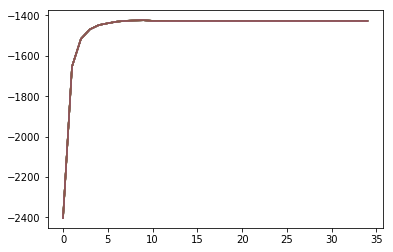

In [199]:
##evaluate
testfile = sdeptest[0][0]
Atry = np.array(initialTransition)
print(A)
B = calculateBMatrix(testfile,mn,cov,5)
logg = np.array(calculateAlphaBetaTildeG(A,B,initialProbabilities)[2])
print(np.sum(logg))
for i in range(16):
    plt.plot(logprobs[i])
plt.show()

### 